# Land Use / Land Cover Segmentation Using Sentinel-2 and Random Forest

This workflow demonstrates how to use [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) satellite imagery for segmenting land use / land cover (LULC) using a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier. We will pursue this objective by integrating ground truth forest areas from the **National Forest Classification Dataset (LULC)** from 2018. To make this scalable to all of Vanuatu, we use an [administrative boundaries dataset from Pacific data hub](https://pacificdata.org/data/dataset/2016_vut_phc_admin_boundaries/resource/66ae054b-9b67-4876-b59c-0b078c31e800).

In this notebook, we will demonstrate the following:

1. **Data Acquisition**:
   - We use **Sentinel-2 L2A** data (Level-2A provides surface reflectance) accessed via the [AWS STAC catalog](https://registry.opendata.aws/). The search is filtered by parameters like a region of interest (AOI), time range, and cloud cover percentage to obtain suitable imagery.
   
2. **Preprocessing**:
   - The Sentinel-2 imagery contains several spectral bands (e.g., Red, Green, Blue, and Near-Infrared). These are extracted and combined into a single dataset for analysis. Additionally, the imagery is masked to remove areas outside the AOI and focus on the relevant pixels.
  
3. **Feature Extraction**:
   - Features for the classifier are extracted from the Sentinel-2 spectral bands. Here, we will use the reflectance values from the Red, Green, Blue, and Near-Infrared (NIR) bands. We will mask out clouds from these bands before further analysis.

4. **Ground Truth Data Integration**:
   - A shapefile containing polygons attributed by land cover/land use is loaded into a [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). This allows us to create multi-class labels for the pixels in the Sentinel-2 imagery.
  
5. **Data Splitting**:
   - To ensure correct model training, we split the features and labels into training (80%) and testing (20%) sets. A 'seed' value is used for the random number generator to ensure this random split is reproducible.

6. **Random Forest Classification**:
   - We train a **Random Forest** classifier to predict planted forest areas. The `n_estimators` parameter is a key hyperparameter, determining the number of decision trees in the forest. Random Forest leverages the collective wisdom of multiple decision trees to make accurate predictions.

7. **Prediction**:
   - We will use the trained classifier to predict the likelihood of lulc types for each pixel in the image. 

8. **Evaluation**:
   - After making predictions on the test set, we evaluate the model's performance using metrics such as accuracy and F1-score. This allows us to assess the performance of the Random Forest model and the effectiveness of the selected features.

9. **Visualization**:
   - We visualize the predictions by plotting the classified map, where lulc types are indicated by specific color codes.

At the end, you will have trained a model to predict land use + land cover in Vanuatu.

![result](https://github.com/user-attachments/assets/6794df2b-45b4-4c6a-923b-98b33e305a39)

In [1]:
import dask.dataframe as dd
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import odc.stac
import rasterio.features
import xarray as xr
from dask import delayed, compute
from geocube.api.core import make_geocube
from pystac_client import Client
from shapely.geometry import Polygon, shape
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Data Acquisition

Let's read the LULC data into a GeoDataFrame. 

A [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/geodataframe.html) is a type of data structure used to store geographic data in Python, provided by the [GeoPandas](https://geopandas.org/en/stable/) library. It extends the functionality of a pandas DataFrame to handle spatial data, enabling geospatial analysis and visualization. Like a pandas DataFrame, a GeoDataFrame is a tabular data structure with labeled axes (rows and columns), but it adds special features to work with geometric objects, such as:
- a geometry column
- a CRS
- accessibility to spatial operations (e.g.  intersection, union, buffering, and spatial joins)

In [2]:
lulc_gdf = gpd.read_file("./lulc_utm.geojson")

In [3]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_iid_4326.geojson")

In [4]:
len(lulc_gdf), len(admin_boundaries_gdf)

(194764, 91)

We can check out the attributes associated with this dataset:

In [4]:
lulc_gdf.columns

Index(['fid', 'is_name', 'lulc_2008', 'lulc_2018', 'area_ha', 'geometry'], dtype='object')

Let's see which classes are available to us in the most recent LULC column.

In [5]:
lulc_gdf.lulc_2018.unique()

array(['Bareland', 'Coconut Plantation', 'Dense Forest', 'Grassland',
       'Open Forest', 'Settlement', 'Water', None, 'Agriculture', 'Cloud',
       'other', 'Shrubs', 'Plantation Forest', 'Mangroves'], dtype=object)

And view a subset of the data (shuffled for more variety in the 10 samples):

In [6]:
lulc_gdf.sample(frac=1).head(10)

,fid,is_name,lulc_2008,lulc_2018,area_ha,geometry
156614,156615.0,Malekula,None,Shrubs,0.008944,"MULTIPOLYGON (((765579.817 8166794.627, 765576..."
139574,139575.0,Tanna,None,Dense Forest,11.787100,"MULTIPOLYGON (((966126.699 7825049.183, 966116..."
62658,62659.0,Espiritu Santo,None,Dense Forest,21.915700,"MULTIPOLYGON (((683057.011 8310240.174, 683083..."
100720,100721.0,Gaua,None,Shrubs,0.011069,"MULTIPOLYGON (((766657.5 8421977.5, 766630.578..."
24342,24343.0,Efate,Open Forest,Settlement,1.851110,"MULTIPOLYGON (((857238.933 8033297.5, 857242.5..."
42786,42787.0,Espiritu Santo,None,Bareland,2.953860,"MULTIPOLYGON (((667747.5 8372177.5, 667747.5 8..."
98375,98376.0,Espiritu Santo,None,Water,0.004130,"MULTIPOLYGON (((696069.876 8318830.23, 696067...."
121238,121239.0,Malekula,None,Open Forest,0.003133,"MULTIPOLYGON (((759516.277 8192803.915, 759511..."
91412,91413.0,Espiritu Santo,None,Shrubs,1.983490,"MULTIPOLYGON (((677704.122 8347833.266, 677701..."
104372,104373.0,Malekula,None,Coconut Plantation,2.084320,"MULTIPOLYGON (((754747.5 8226977.5, 754736.602..."


We can also plot the vector dataset, and color code the polygons by the relevant LULC column.

<Axes: >

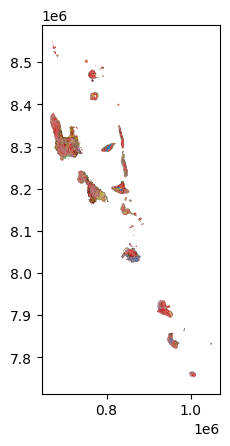

In [7]:
lulc_gdf.plot(column='lulc_2018')

Break down the LULC into subsets per admin boundary.

In [15]:
# Ensure both GeoDataFrames have the same CRS
if lulc_gdf.crs != admin_boundaries_gdf.crs:
    admin_boundaries_gdf = admin_boundaries_gdf.to_crs(lulc_gdf.crs)

clipped_gdfs = []

# Clip polygons by each boundary and save as separate GeoDataFrame
i = 0
for _, boundary in admin_boundaries_gdf.iterrows():
    boundary_geom = boundary.geometry
    clipped = gpd.clip(lulc_gdf, boundary_geom)
    if not clipped.empty:
        clipped["admin_boundary_id"] = boundary["iid"]  # Assign an ID or attribute from the admin boundary
        clipped_gdfs.append(clipped)
        i = i+1

print(i)

# Combine into a dictionary with admin boundary ID as the key
result = {
    row["iid"]: gdf
    for (_, row), gdf in zip(admin_boundaries_gdf.iterrows(), clipped_gdfs)
}

# Save each clipped GeoDataFrame
for admin_id, gdf in result.items():
    gdf.to_file(f"clipped_polygons_{admin_id}.geojson", driver="GeoJSON")
    

91


Create raster image and label xarray datarrays for each admin boundary.

In [ ]:
# Access AWS STAC for Sentinel-2 Data
aws_stac_url = "https://earth-search.aws.element84.com/v1"
stac_client = Client.open(aws_stac_url)

unique_vals = []
nonflat_labels_ = []
nonflat_features_ = []
features_ = []
labels_ = []
widths_ = []
heights_ = []

i=0
for g in glob.glob("/Users/lillythomas/Documents/work/clay/lt/servir/model/docs/tutorials/geos/*.geojson"):
    gdf_ = gpd.read_file(g)
    # Get the bounds of the forest polygons to define the AOI
    aoi = gdf_.to_crs(epsg="4326").total_bounds  # (minx, miny, maxx, maxy)
    # Search Sentinel-2 data on AWS with cloud cover less than 20%
    s2_search = stac_client.search(
        collections=["sentinel-2-l2a"],
        bbox=list(aoi),
        datetime="2018-01-01/2018-12-31", 
        query={"eo:cloud_cover": {"lt": 5}}  # Filter by cloud cover < 5%
    )
    # Retrieve all items from search results
    s2_items = s2_search.item_collection()
    i = i+1
    try:
        s2_data = odc.stac.load(
            items=s2_items,
            bands=["red", "green", "blue", "nir", "scl"],
            bbox=aoi,
            chunks={'x': 1024, 'y': 1024, 'bands': -1, 'time': -1},
            resolution=80,
        )
        s2_data_nodata = s2_data["scl"].nodata
        width, height = s2_data.x.size, s2_data.y.size
        widths_.append(width)
        heights_.append(height)
        epsg = s2_data.rio.crs.to_epsg()
        bands = ['red', 'green', 'blue', 'nir']
        cloud_classes = [3, 7, 8, 9, 10]  # Cloud-related SCL classes
        cloud_mask = s2_data['scl'].isin(cloud_classes)
        s2_data_masked = s2_data[bands].where(~cloud_mask, drop=False)  # Keep all pixels
        s2_data_composite = s2_data_masked.median(dim='time')
        # Get unique classes and assign integers
        unique_classes = gdf_['lulc_2018'].unique()
        unique_vals.append(unique_classes)
        class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}
        
        # Add numerical column
        gdf_['lulc_2018_numeric'] = gdf_['lulc_2018'].map(class_mapping)
        
        #print(gdf_.lulc_2018.unique(), gdf_.lulc_2018_numeric.unique())
        gdf_ = gdf_.to_crs(epsg=epsg)
        # Define the resolution and bounds based on Sentinel-2 features
        resolution = s2_data.rio.resolution()
        bounds = s2_data.rio.bounds()
        
        # Rasterize the vector dataset to match Sentinel-2
        rasterized_labels = make_geocube(
            vector_data=gdf_,
            measurements=["lulc_2018_numeric"], 
            like=s2_data,  # Align with the features dataset
        )
        
        # The rasterized output is an xarray.Dataset
        #print(np.unique(rasterized_labels["lulc_2018_numeric"].values))
        rasterized_labels = rasterized_labels.where(~np.isnan(rasterized_labels), other=0)  # Replace NaNs with 0
        #print(np.unique(rasterized_labels["lulc_2018_numeric"].values))
        rasterized_labels = rasterized_labels.astype(int)
        #print(np.unique(rasterized_labels["lulc_2018_numeric"].values))
        nonflat_labels_.append(rasterized_labels)
        nonflat_features_.append(s2_data_composite)
        features = s2_data_composite.to_array().stack(flattened_pixel=("y", "x")).transpose("flattened_pixel", "variable")
        labels = rasterized_labels.to_array().stack(flattened_pixel=("y", "x")).transpose("flattened_pixel", "variable").squeeze()
        #print(features.shape, labels.shape)
        features_.append(features)
        labels_.append(labels)
    except:
        print("next: ", i)




In [6]:
len(features_), len(labels_)

(90, 90)

In [7]:
features_[0]

<xarray.DataArray (flattened_pixel: 9858, variable: 4)> Size: 158kB
dask.array<transpose, shape=(9858, 4), dtype=float32, chunksize=(9858, 1), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref      int32 4B 32758
  * variable         (variable) object 32B 'red' 'green' 'blue' 'nir'
  * flattened_pixel  (flattened_pixel) object 79kB MultiIndex
  * y                (flattened_pixel) float64 79kB 8.506e+06 ... 8.499e+06
  * x                (flattened_pixel) float64 79kB 7.477e+05 ... 7.561e+05

In [8]:
features_flattened = xr.concat(features_, dim="flattened_pixel")
labels_flattened = xr.concat(labels_, dim="flattened_pixel")


In [32]:
features_flattened.shape, labels_flattened.shape

((4107840, 4), (4107840,))

## Data Splitting

Now that we have the arrays flattened, we can split the datasets into training and testing partitions. We will reserve 80 percent of the data for training, and 20 percent for testing.

In [9]:
features_flattened.shape, labels_flattened.shape

((4107840, 4), (4107840,))

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_flattened, labels_flattened, test_size=0.2, random_state=42)

Ensure all labels ar ein each partition.

In [11]:
np.unique(y_train), np.unique(y_test) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3286272, 821568, 3286272, 821568)

## Random Forest Classification

Now we will set up a small [random forest classifider](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 10 trees. We use a [seed](https://towardsdatascience.com/why-do-we-set-a-random-state-in-machine-learning-models-bb2dc68d8431) (`random_state`) to ensure reproducibility. Calling the `.fit()` method on the classifier will initiate training.

In [13]:
%%time
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) #n_estimators=10
clf.fit(X_train, y_train)

/Users/lillythomas/Documents/work/clay/lt/servir/model/docs/tutorials/ingarss/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


CPU times: user 19min 25s, sys: 31.7 s, total: 19min 56s
Wall time: 4min 21s


RandomForestClassifier(n_jobs=-1, random_state=42)

## Prediction

Once the classifier is finished training, we can use it to make predictions on our test dataset.

In [14]:
# Test the classifier
y_pred = clf.predict(X_test)

## Evaluation

It's important to know how well our classifier performs relative to the true labels (`y_test`). For this, we can calculate the [accuracy metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to measure agreement between the true and predicted labels.

In [15]:
# Evaluate the performance (you can use metrics like accuracy, F1-score, etc.)
print("Accuracy:", accuracy_score(y_test, y_pred)) #0.60 # 0.6130508977954351 for 50

Accuracy: 0.6135815903248423


We can also plot a confusion matrix to explore per-class performance.

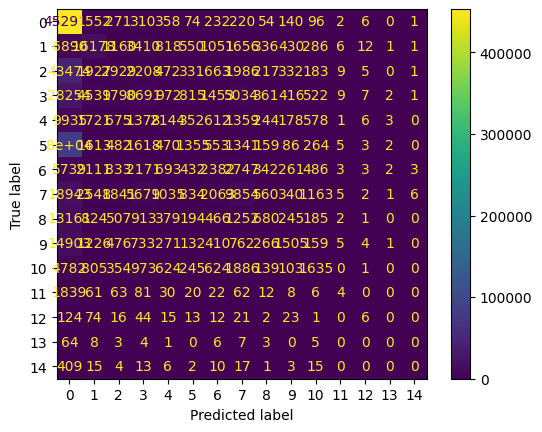

In [39]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

Notice that we see a high variability in the performance across classes. This is likely due to a class imbalance or inter-class differentiation challenge within our training dataset. It's possible that augmentations or class revision may help to address this.

## Visualization

If we want to generate predictions for the entire dataset in order to plot a map of predicted LULC for the entire area of interest, we can do this using the full (un-partitioned) features dataset.

In [ ]:
predictions = []
labels_reshaped = []
for ft, lbl, w, h in zip(features_, nonflat_labels_, widths_, heights_):
    y_pred_full = clf.predict(ft)
    predicted_map = y_pred_full.reshape((h, w))
    predicted_map_xr = xr.DataArray(data=predicted_map, coords=lbl.coords)
    print(np.unique(y_pred_full))
    predictions.append(predicted_map_xr)
    labels_reshaped.append(lbl)
    

In [55]:
predictions[0], labels_reshaped[0]

(<xarray.DataArray (y: 93, x: 106)> Size: 79kB
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(93, 106))
 Coordinates:
   * y            (y) float64 744B 8.506e+06 8.506e+06 ... 8.499e+06 8.499e+06
   * x            (x) float64 848B 7.477e+05 7.478e+05 ... 7.56e+05 7.561e+05
     spatial_ref  int64 8B 0,
 <xarray.Dataset> Size: 80kB
 Dimensions:            (y: 93, x: 106)
 Coordinates:
   * y                  (y) float64 744B 8.506e+06 8.506e+06 ... 8.499e+06
   * x                  (x) float64 848B 7.477e+05 7.478e+05 ... 7.561e+05
     spatial_ref        int64 8B 0
 Data variables:
     lulc_2018_numeric  (y, x) int64 79kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0)

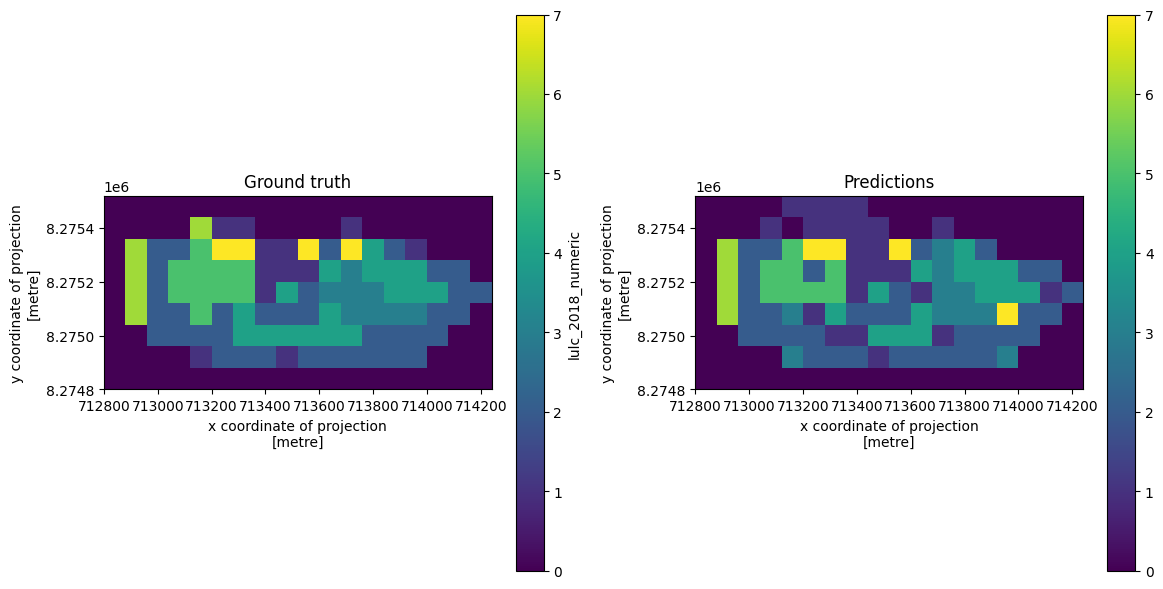

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

labels_reshaped[30]["lulc_2018_numeric"].plot(ax=axes[0], cmap="viridis")
axes[0].set_title("Ground truth")
axes[0].set_aspect('equal')

predictions[30].plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Predictions")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [63]:
predictions[30]

<xarray.DataArray 'value' (y: 9, x: 18)> Size: 1kB
array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 6, 2, 2, 5, 7, 7, 1, 1, 7, 2, 3, 4, 2, 0, 0, 0, 0],
       [0, 6, 2, 5, 5, 2, 5, 1, 1, 1, 4, 3, 4, 4, 4, 2, 2, 0],
       [0, 6, 2, 5, 5, 5, 5, 1, 4, 2, 1, 3, 3, 4, 4, 4, 1, 2],
       [0, 6, 2, 2, 3, 1, 4, 2, 2, 2, 4, 3, 3, 3, 7, 2, 2, 0],
       [0, 0, 2, 2, 2, 2, 1, 1, 4, 4, 4, 1, 2, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Coordinates:
  * y            (y) float64 72B 8.275e+06 8.275e+06 ... 8.275e+06 8.275e+06
  * x            (x) float64 144B 7.128e+05 7.129e+05 ... 7.141e+05 7.142e+05
    spatial_ref  int64 8B 0

In [70]:
predictions[30].values

array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 6, 2, 2, 5, 7, 7, 1, 1, 7, 2, 3, 4, 2, 0, 0, 0, 0],
       [0, 6, 2, 5, 5, 2, 5, 1, 1, 1, 4, 3, 4, 4, 4, 2, 2, 0],
       [0, 6, 2, 5, 5, 5, 5, 1, 4, 2, 1, 3, 3, 4, 4, 4, 1, 2],
       [0, 6, 2, 2, 3, 1, 4, 2, 2, 2, 4, 3, 3, 3, 7, 2, 2, 0],
       [0, 0, 2, 2, 2, 2, 1, 1, 4, 4, 4, 1, 2, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [73]:
prediction_gdfs = []

for pred in predictions:
    compatible_array = pred.astype("int32")
    
    # Rasterize to polygons
    polygons = list(
        rasterio.features.shapes(compatible_array.values, transform=compatible_array.rio.transform())
    )
    
    # Convert polygons to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        [{"geometry": shape(geom), "value": value} for geom, value in polygons],
        crs="EPSG:4326",
    )
    #print(gdf)
    print(gdf.value.unique())
    prediction_gdfs.append(gdf)


[ 5.  3.  4.  1.  9.  8.  7. 10.  2.  6.  0.]
[1. 6. 5. 9. 2. 3. 4. 0.]
[ 7.  3.  2.  0.  6.  4.  5.  9. 10.  1.]
[2. 1. 4. 3. 5. 0.]
[2. 6. 3. 8. 1. 7. 4. 5. 0.]
[ 1.  2.  7.  8.  4.  3.  5.  6.  9. 10. 11.  0. 14. 12.]
[ 3.  6.  2.  8.  7.  1.  4. 10.  5.  9.  0. 11. 12. 13. 14.]
[ 6.  1.  4.  3.  5.  7. 10.  2.  9.  0.]
[ 8.  7.  3.  6.  4.  2.  1.  5. 11. 10.  0.  9.]
[ 4.  3.  7.  1.  2.  6.  9.  0.  8.  5. 12. 10.]
[1. 0.]
[1. 0. 5. 2. 7. 6. 3.]
[0. 1.]
[2. 9. 1. 0.]
[ 2.  5.  7.  3.  6.  4. 10.  0.  1.  9.  8.]
[1. 3. 0.]
[1. 3. 2. 0.]
[ 3.  4.  2.  1.  7.  9.  6.  5.  0. 10.  8.]
[2. 1. 7. 3. 0.]
[ 2.  1.  8.  5.  3.  7.  4. 10.  6.  0.]
[5. 0. 4. 3. 1. 2. 9. 6.]
[2. 5. 1. 6. 4. 3. 7. 8. 0.]
[ 2.  6.  4.  1.  5.  3.  0. 12.  8.  7.  9. 10.]
[ 2.  3.  6.  1. 11.  4.  7.  9.  5.  8. 10.  0. 12.]
[2. 6. 1. 0. 3. 5. 7. 8. 4. 9.]
[ 1.  6.  7.  3.  8.  5.  2.  4. 10.  9.  0.]
[ 1.  7.  3.  6.  0.  8.  2.  4.  5. 10.]
[ 3.  1.  2.  7. 12. 11.  6.  5.  4.  0.]
[5. 1. 4. 3. 2. 0.]
[ 7. 

In [74]:
# Combine into a single GeoDataFrame
combined_prediction_gdf = gpd.pd.concat(prediction_gdfs, ignore_index=True)

print(combined_prediction_gdf)

combined_prediction_gdf.to_file("./predicted_lulc_utm_2018.geojson", driver="GeoJSON")

                                                 geometry  value
0       POLYGON ((751360 8506080, 751360 8506000, 7514...    5.0
1       POLYGON ((751760 8506080, 751760 8506000, 7518...    5.0
2       POLYGON ((750800 8506000, 750800 8505920, 7508...    3.0
3       POLYGON ((751200 8506000, 751200 8505920, 7512...    4.0
4       POLYGON ((751280 8506000, 751280 8505920, 7513...    5.0
...                                                   ...    ...
125729  POLYGON ((803840 8170160, 803840 8170000, 8039...    3.0
125730  POLYGON ((803440 8170080, 803440 8170000, 8035...    7.0
125731  POLYGON ((803600 8170720, 803600 8170560, 8035...    2.0
125732  POLYGON ((803120 8170400, 803120 8169920, 8040...    0.0
125733  POLYGON ((803120 8170800, 803120 8170480, 8032...    0.0

[125734 rows x 2 columns]


Now, let's predict on more recent data (2024 composite).

In [ ]:
# Access AWS STAC for Sentinel-2 Data
aws_stac_url = "https://earth-search.aws.element84.com/v1"
stac_client = Client.open(aws_stac_url)

nonflat_features_new = []
features_new = []
widths_new = []
heights_new = []
predictions_new = []
prediction_gdfs_new = []

i=0
for g in glob.glob("/Users/lillythomas/Documents/work/clay/lt/servir/model/docs/tutorials/geos/*.geojson"):
    gdf_ = gpd.read_file(g)
    # Get the bounds of the forest polygons to define the AOI
    aoi = gdf_.to_crs(epsg="4326").total_bounds  # (minx, miny, maxx, maxy)
    # Search Sentinel-2 data on AWS with cloud cover less than 20%
    s2_search = stac_client.search(
        collections=["sentinel-2-l2a"],
        bbox=list(aoi),
        datetime="2024-01-01/2024-12-31", 
        query={"eo:cloud_cover": {"lt": 5}}  # Filter by cloud cover < 5%
    )
    # Retrieve all items from search results
    s2_items = s2_search.item_collection()
    i = i+1
    try:
        s2_data = odc.stac.load(
            items=s2_items,
            bands=["red", "green", "blue", "nir", "scl"],
            bbox=aoi,
            chunks={'x': 1024, 'y': 1024, 'bands': -1, 'time': -1},
            resolution=80,
        )
        s2_data_nodata = s2_data["scl"].nodata
        width, height = s2_data.x.size, s2_data.y.size
        widths_new.append(width)
        heights_new.append(height)
        epsg = s2_data.rio.crs.to_epsg()
        bands = ['red', 'green', 'blue', 'nir']
        cloud_classes = [3, 7, 8, 9, 10]  # Cloud-related SCL classes
        cloud_mask = s2_data['scl'].isin(cloud_classes)
        s2_data_masked = s2_data[bands].where(~cloud_mask, drop=False)  # Keep all pixels
        s2_data_composite = s2_data_masked.median(dim='time')
        
        resolution = s2_data.rio.resolution()
        bounds = s2_data.rio.bounds()
        
        nonflat_features_new.append(s2_data_composite)
        features = s2_data_composite.to_array().stack(flattened_pixel=("y", "x")).transpose("flattened_pixel", "variable")
        #print(features.shape)
        features_new.append(features)
        y_pred_full = clf.predict(features)
        #print(y_pred_full.shape)
        #predictions.append(y_pred_full)
        predicted_map = y_pred_full.reshape((height, width))
        #print(s2_data_composite.coords)
        predicted_map_xr = xr.DataArray(data=predicted_map, coords=s2_data_composite.coords)
        #print(np.unique(y_pred_full))
        predictions_new.append(predicted_map_xr)
        compatible_array = predicted_map_xr.astype("int32")
    
        # Rasterize to polygons
        polygons = list(
            rasterio.features.shapes(compatible_array.values, transform=compatible_array.rio.transform())
        )
        
        # Convert polygons to GeoDataFrame
        gdf = gpd.GeoDataFrame(
            [{"geometry": shape(geom), "value": value} for geom, value in polygons],
            crs="EPSG:4326",
        )
        #print(gdf)
        #print(gdf.value.unique())
        prediction_gdfs_new.append(gdf)
        
    except:
        print("next: ", i)

In [108]:
# Combine into a single GeoDataFrame
combined_prediction_new_gdf = gpd.pd.concat(prediction_gdfs_new, ignore_index=True)

                                                 geometry  value
0       POLYGON ((752080 8506080, 752080 8506000, 7521...    1.0
1       POLYGON ((752880 8505600, 752880 8505440, 7529...    7.0
2       POLYGON ((752800 8505600, 752800 8505520, 7527...    3.0
3       POLYGON ((752960 8505520, 752960 8505440, 7530...    5.0
4       POLYGON ((752720 8505440, 752720 8505360, 7528...    2.0
...                                                   ...    ...
254825  POLYGON ((803440 8170000, 803440 8169920, 8035...    1.0
254826  POLYGON ((803840 8170000, 803840 8169920, 8039...    1.0
254827  POLYGON ((803920 8170000, 803920 8169920, 8040...    7.0
254828  POLYGON ((804000 8170000, 804000 8169920, 8040...    2.0
254829  POLYGON ((803120 8170800, 803120 8170560, 8032...    0.0

[254830 rows x 2 columns]


Add the string class back in:

In [109]:
unique_classes_full = lulc_gdf['lulc_2018'].unique()
class_mapping_full = {cls: i+1 for i, cls in enumerate(unique_classes_full)}

In [110]:
class_mapping_full

{'Bareland': 1,
 'Coconut Plantation': 2,
 'Dense Forest': 3,
 'Grassland': 4,
 'Open Forest': 5,
 'Settlement': 6,
 'Water': 7,
 None: 8,
 'Agriculture': 9,
 'Cloud': 10,
 'other': 11,
 'Shrubs': 12,
 'Plantation Forest': 13,
 'Mangroves': 14}

In [111]:
reversed_class_mapping_full = {v: k for k, v in class_mapping_full.items()}

# Add a new column for string class names based on the integer classes
combined_prediction_new_gdf["lulc"] = combined_prediction_new_gdf["value"].map(reversed_class_mapping_full)

print(combined_prediction_new_gdf.head())

                                            geometry  value  \
0  POLYGON ((752080 8506080, 752080 8506000, 7521...    1.0   
1  POLYGON ((752880 8505600, 752880 8505440, 7529...    7.0   
2  POLYGON ((752800 8505600, 752800 8505520, 7527...    3.0   
3  POLYGON ((752960 8505520, 752960 8505440, 7530...    5.0   
4  POLYGON ((752720 8505440, 752720 8505360, 7528...    2.0   

                 lulc  
0            Bareland  
1               Water  
2        Dense Forest  
3         Open Forest  
4  Coconut Plantation  


In [113]:
combined_prediction_new_gdf.to_file("./predicted_lulc_utm_2024.geojson", driver="GeoJSON")

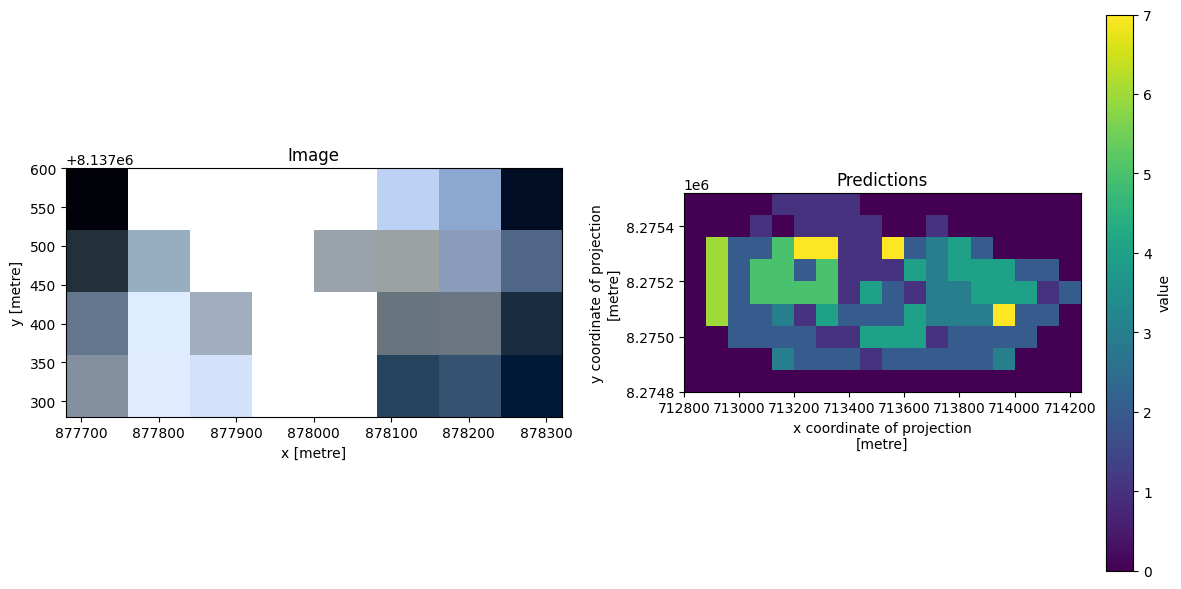

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

nonflat_features_new[30][["red", "green", "blue"]].to_array("band").plot.imshow(rgb="band", robust=True, ax=axes[0])
axes[0].set_title("Image")
axes[0].set_aspect('equal')

predictions[30].plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Predictions")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

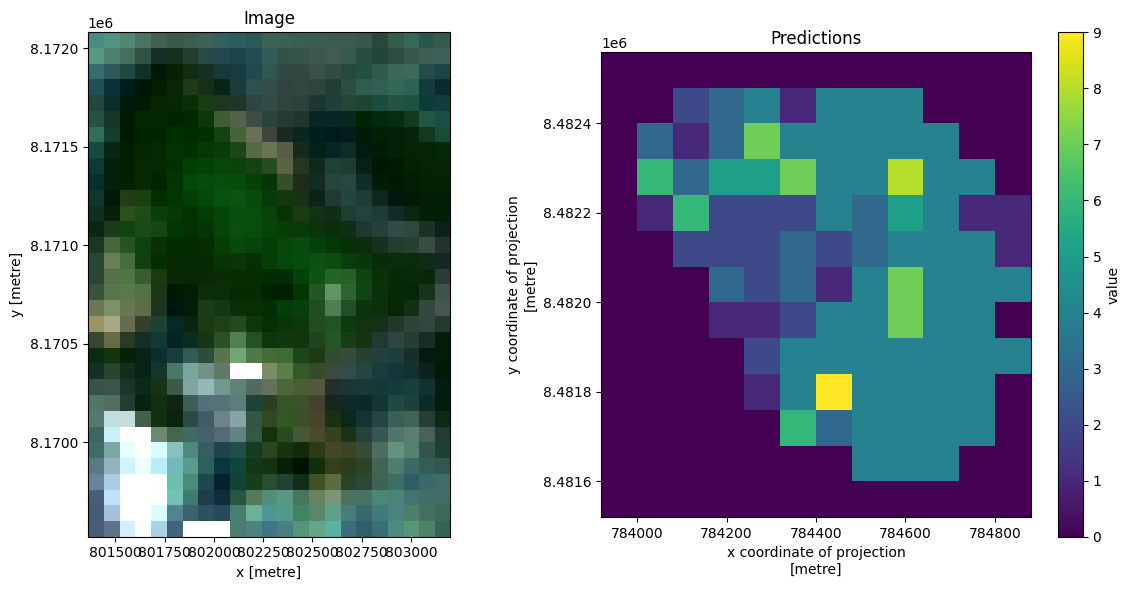

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

nonflat_features_new[40][["red", "green", "blue"]].to_array("band").plot.imshow(rgb="band", robust=True, ax=axes[0])
axes[0].set_title("Image")
axes[0].set_aspect('equal')

predictions[40].plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Predictions")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

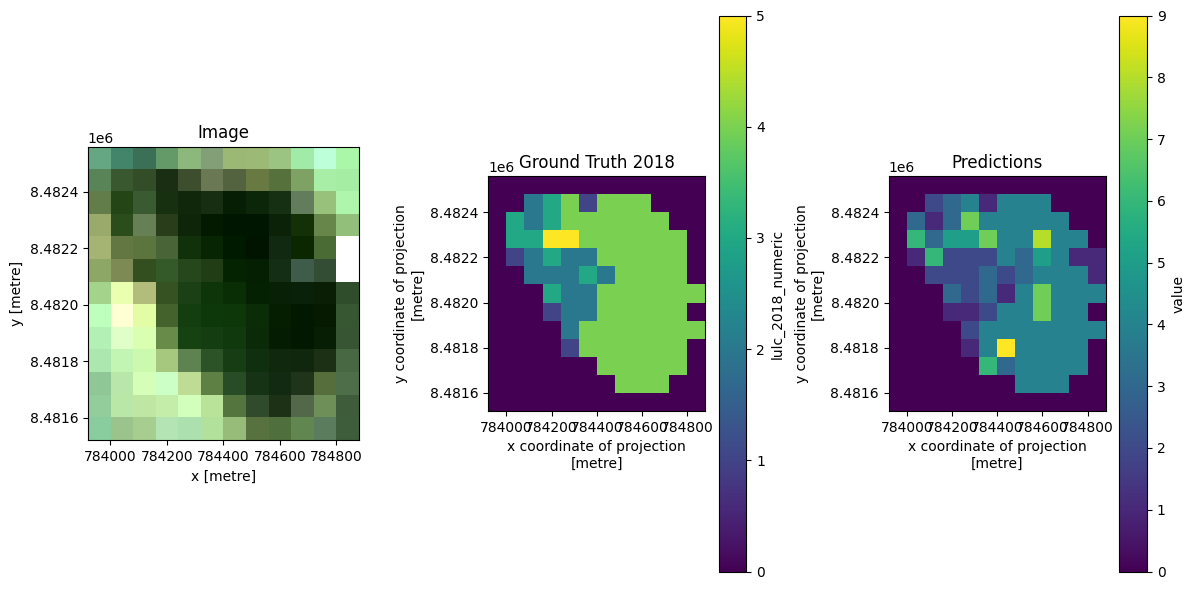

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

nonflat_features_[40][["red", "green", "blue"]].to_array("band").plot.imshow(rgb="band", robust=True, ax=axes[0])
axes[0].set_title("Image")
axes[0].set_aspect('equal')

labels_reshaped[40]["lulc_2018_numeric"].plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Ground Truth 2018")
axes[1].set_aspect('equal')

predictions[40].plot(ax=axes[2], cmap="viridis")
axes[2].set_title("Predictions")
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()